In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.restoration import denoise_tv_bregman
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
#Load the data.
train = pd.read_json("input/train.json")

In [3]:
test = pd.read_json("input/test.json")

#Intro about the Data.

Sentinet -1 sat is at about 680 Km above earth. Sending pulses of signals at a particular angle of incidence and then recoding it back. Basically those reflected signals are called backscatter. The data we have been given is backscatter coefficient which is the conventional form of backscatter coefficient given by:

$σo (dB) = βo (dB) + 10log10 [ sin(ip) / sin (ic)] $

where
1. ip=is angle of incidence for a particular pixel
2. 'ic ' is angle of incidence for center of the image
3. K =constant.

We have been given $σo$ directly in the data. 
###Now coming to the features of $σo$
Basically σo varies with the surface on which the signal is scattered from. For example, for a particular angle of incidence, it varies like:
*             WATER...........           SETTLEMENTS........           AGRICULTURE...........          BARREN........

1.**HH:**     -27.001   ................                     2.70252       .................                -12.7952        ................    -17.25790909

2.**HV: **      -28.035      ................            -20.2665             ..................          -21.4471       .................     -20.019

As you can see, the HH component varies a lot but HV doesn't.
**I don't have the data for scatter from ship, but being a metal object, it should vary differently as compared to ice object.**

###WTF is HH HV?

Ok, so this Sentinal Settalite is equivalent to RISTSAT(an Indian remote sensing Sat) and they only Transmit pings in H polarization, **AND NOT IN V polarization**.  Those H-pings gets scattered, objects change their polarization and returns as a mix of H and V.
**Since Sentinel has only H-transmitter, return signals are of the form of HH and HV only**. Don't ask why VV is not given(because Sentinel don't have V-ping transmitter).

Now coming to features, for the purpose of this demo code, I am extracting all two bands and taking avg of them as 3rd channel to create a 3-channel RGB equivalent. 


In [4]:
from scipy.ndimage import rotate as rot
def augment(images):
    image_mirror_lr = []
    image_mirror_ud = []
    image_rotate30 = []
    image_rotate60 = []
    image_rotate110 = []
    image_rotate155 = []
    for i in range(0,images.shape[0]):
        band_1 = images[i,:,:,0]
        band_2 = images[i,:,:,1]
            
        # mirror left-right
        band_1_mirror_lr = np.flip(band_1, 0)
        band_2_mirror_lr = np.flip(band_2, 0)
        image_mirror_lr.append(np.dstack((band_1_mirror_lr, band_2_mirror_lr)))
        
        # mirror up-down
        band_1_mirror_ud = np.flip(band_1, 1)
        band_2_mirror_ud = np.flip(band_2, 1)
        image_mirror_ud.append(np.dstack((band_1_mirror_ud, band_2_mirror_ud)))
        
        #rotate 
        band_1_rotate = rot(band_1, 30, reshape=False, mode='reflect')
        band_2_rotate = rot(band_2, 30, reshape=False, mode='reflect')
        image_rotate30.append(np.dstack((band_1_rotate, band_2_rotate)))
        
        band_1_rotate = rot(band_1, 60, reshape=False, mode='reflect')
        band_2_rotate = rot(band_2, 60, reshape=False, mode='reflect')
        image_rotate60.append(np.dstack((band_1_rotate, band_2_rotate)))

        band_1_rotate = rot(band_1, 110, reshape=False, mode='reflect')
        band_2_rotate = rot(band_2, 110, reshape=False, mode='reflect')
        image_rotate110.append(np.dstack((band_1_rotate, band_2_rotate)))
        
        band_1_rotate = rot(band_1, 155, reshape=False, mode='reflect')
        band_2_rotate = rot(band_2, 155, reshape=False, mode='reflect')
        image_rotate155.append(np.dstack((band_1_rotate, band_2_rotate)))
        
    mirrorlr = np.array(image_mirror_lr)
    mirrorud = np.array(image_mirror_ud)
    rotated30 = np.array(image_rotate30)
    rotated60 = np.array(image_rotate60)
    rotated110 = np.array(image_rotate110)
    rotated155 = np.array(image_rotate155)
    images = np.concatenate((images, mirrorlr, mirrorud, rotated30, rotated60, rotated110, rotated155))
    return images

In [6]:
X_band_1=np.array([denoise_tv_bregman(np.array(band).reshape(75, 75),weight=0.5) for band in train["band_1"]])
X_band_2=np.array([denoise_tv_bregman(np.array(band).reshape(75, 75),weight=0.5) for band in train["band_2"]])

X_band_1=np.array([np.array(band).astype(np.float32) for band in X_band_1])
X_band_2=np.array([np.array(band).astype(np.float32) for band in X_band_2])

X_band_1=np.array([band-band.mean() for band in X_band_1])
X_band_2=np.array([band-band.mean() for band in X_band_2])

X_band_1=np.array([band/band.std() for band in X_band_1])
X_band_2=np.array([band/band.std() for band in X_band_2])

In [ ]:
#X_band_1=np.array([band.reshape(75, 75) for band in X_band_1])
#X_band_2=np.array([band.reshape(75, 75) for band in X_band_2])

In [7]:
#X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)
X_train2 = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis]], axis=-1)
target_train=train['is_iceberg']

In [8]:
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train2, target_train, random_state=1, train_size=0.75)

C:\Anaconda3\envs\tfgpu\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [ ]:
#X_train_cv = augment(X_train_cv)
#y_train_cv = np.concatenate((y_train_cv,y_train_cv, y_train_cv, y_train_cv,y_train_cv,y_train_cv,y_train_cv))

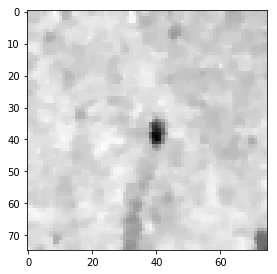

In [9]:
fig = plt.figure(200, figsize=(15, 15))
ax = fig.add_subplot(3, 3, 1)
ax.imshow(X_train2[14,:,:,0],cmap='Greys')
plt.show()

In [ ]:
fig = plt.figure(4, figsize=(15, 15))
ax = fig.add_subplot(1, 3, 1)
image1 = np.array(train["band_1"][8]).reshape(75, 75)
ax.imshow(image1,cmap='Greys')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(denoise_tv_bregman(image1,weight=0.1),cmap='Greys')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(denoise_tv_bregman(image1,weight=0.5),cmap='Greys')
plt.show()

In [ ]:
fig = plt.figure(200, figsize=(20, 200))
j=1
for i in range(0,100):
    if(target_train[i]==1):
        ax = fig.add_subplot(100, 11, j)
        ax.imshow(X_train2[i,:,:,0],cmap='Greys')
        j+=1
plt.show()

In [ ]:
fig = plt.figure(200, figsize=(20, 200))
j=1
for i in range(0,100):
    if(target_train[i]==0):
        ax = fig.add_subplot(100, 11, j)
        ax.imshow(X_train2[i,:,:,0],cmap='Greys')
        j+=1
plt.show()

In [ ]:
#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(X_train2[1,:,:,0], 'iceberg')

That's a cool looking iceberg we have. Remember, in radar data, the shape of the iceberg is going to be like a mountain as shown in here. Since this is not a actual image but scatter from radar, the shape is going to have peaks and distortions like these. The shape of the ship is going to be like a point, may be like a elongated point. From here the structural differences arise and we can exploit those differences using a CNN. It would be helpful if we can create composite images using the backscatter from radar.

In [ ]:
plotmy3d(X_train2[14,:,:,1], 'Ship')

That's a ship, looks like a elongated point. We don't have much resolution in images to visualize the shape of the ship. However CNN is here to help. There are few papers on ship iceberg classification like this:
http://elib.dlr.de/99079/2/2016_BENTES_Frost_Velotto_Tings_EUSAR_FP.pdf
However their data have much better resolution so I don't  feel that the CNN they used would be suitable here.

In [10]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import keras.regularizers as reg
import time

Using TensorFlow backend.


In [11]:
def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

In [40]:
def getModel():
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(3,3), input_shape=(75,75,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(128, kernel_size=(2, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(64, kernel_size=(2,2), input_shape=(75,75,2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    #model.add(Dropout(0.7))
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    #model.add(Dropout(0.7))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.00015)
    #mypotim=SGD(lr=0.001,decay=1e-4, momentum=0.9,nesterov=True)
    
    model.compile(loss='binary_crossentropy', optimizer = mypotim, metrics=['accuracy'])

    model.summary()
    return model


In [41]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='wrap')
datagen.fit(X_train_cv)

C:\Anaconda3\envs\tfgpu\lib\site-packages\keras\preprocessing\image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1203, 75, 75, 2) (2 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


In [42]:
import os
gmodel=getModel()
batch_size = 32
ts = str(int(time.time()))
file_path = ".model_weights_generator"+ts+".hdf5"
gmodel.fit_generator(datagen.flow(X_train_cv, y_train_cv, batch_size=batch_size),
                    steps_per_epoch=len(X_train_cv) / batch_size,
                    epochs=200,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=get_callbacks(filepath=file_path, patience=200))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 73, 73, 64)        1216      
_________________________________________________________________
activation_59 (Activation)   (None, 73, 73, 64)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
activation_60 (Activation)   (None, 34, 34, 128)       0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 128)       65664     
__________

C:\Anaconda3\envs\tfgpu\lib\site-packages\keras\preprocessing\image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1203, 75, 75, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/200
38/37 [==============================] - 2s - loss: 0.6728 - acc: 0.5777 - val_loss: 0.6406 - val_acc: 0.6035
Epoch 2/200
38/37 [==============================] - 1s - loss: 0.6365 - acc: 0.6350 - val_loss: 0.5846 - val_acc: 0.6658
Epoch 3/200
38/37 [==============================] - 1s - loss: 0.5780 - acc: 0.6948 - val_loss: 0.5175 - val_acc: 0.7581
Epoch 4/200
38/37 [==============================] - 1s - loss: 0.5415 - acc: 0.7376 - val_loss: 0.4762 - val_acc: 0.7980
Epoch 5/200
38/37 [==============================] - 1s - loss: 0.4864 - acc: 0.7749 - val_loss: 0.4016 - val_acc: 0.8354
Epoch 6/200
38/37 [==============================] - 1s - loss: 0.4940 - acc: 0.7606 - val_loss: 0.3748 - val_acc: 0.8653
Epoch 7/200
38/37 [==============================] - 1s - loss: 0.4497 - acc: 0.7908 - val_loss: 0.3383 - val_acc: 0.8703
Epoch 8/200
38/37 [==============================] - 1s - loss: 0.4084 - acc: 0.8248 - val_loss: 0.3056 - val_acc: 0.8653
Epoch 9/200
38/37 [=====

38/37 [==============================] - 1s - loss: 0.2586 - acc: 0.8933 - val_loss: 0.2801 - val_acc: 0.8828
Epoch 68/200
38/37 [==============================] - 1s - loss: 0.2643 - acc: 0.8879 - val_loss: 0.2451 - val_acc: 0.9027
Epoch 69/200
38/37 [==============================] - 1s - loss: 0.2587 - acc: 0.8840 - val_loss: 0.2000 - val_acc: 0.9102
Epoch 70/200
38/37 [==============================] - 1s - loss: 0.2776 - acc: 0.8810 - val_loss: 0.2370 - val_acc: 0.8828
Epoch 71/200
38/37 [==============================] - 1s - loss: 0.2644 - acc: 0.8868 - val_loss: 0.2065 - val_acc: 0.9227
Epoch 72/200
38/37 [==============================] - 1s - loss: 0.2299 - acc: 0.9073 - val_loss: 0.2045 - val_acc: 0.9202
Epoch 73/200
38/37 [==============================] - 1s - loss: 0.2491 - acc: 0.9007 - val_loss: 0.2519 - val_acc: 0.8928
Epoch 74/200
38/37 [==============================] - 1s - loss: 0.2410 - acc: 0.8994 - val_loss: 0.1936 - val_acc: 0.9102
Epoch 75/200
38/37 [=========

38/37 [==============================] - 1s - loss: 0.2275 - acc: 0.9007 - val_loss: 0.2250 - val_acc: 0.9077
Epoch 134/200
38/37 [==============================] - 1s - loss: 0.2318 - acc: 0.9073 - val_loss: 0.1816 - val_acc: 0.9377
Epoch 135/200
38/37 [==============================] - 1s - loss: 0.2239 - acc: 0.9027 - val_loss: 0.2003 - val_acc: 0.9102
Epoch 136/200
38/37 [==============================] - 1s - loss: 0.2221 - acc: 0.9095 - val_loss: 0.2227 - val_acc: 0.9002
Epoch 137/200
38/37 [==============================] - 1s - loss: 0.2093 - acc: 0.9246 - val_loss: 0.1936 - val_acc: 0.9252
Epoch 138/200
38/37 [==============================] - 1s - loss: 0.2142 - acc: 0.9092 - val_loss: 0.1966 - val_acc: 0.9127
Epoch 139/200
38/37 [==============================] - 1s - loss: 0.2111 - acc: 0.9114 - val_loss: 0.2040 - val_acc: 0.9152
Epoch 140/200
38/37 [==============================] - 1s - loss: 0.2071 - acc: 0.9147 - val_loss: 0.2238 - val_acc: 0.9077
Epoch 141/200
38/37 [=

38/37 [==============================] - 1s - loss: 0.1725 - acc: 0.9364 - val_loss: 0.1980 - val_acc: 0.9277
Epoch 200/200
38/37 [==============================] - 1s - loss: 0.1901 - acc: 0.9197 - val_loss: 0.2173 - val_acc: 0.9002


In [35]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_train_cv, y_train_cv, verbose=1)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

401/401 [==============================] - 0s     
Test loss: 0.165269682458
Test accuracy: 0.932668329474
1088/1203 [==========================>...] - ETA: 0sTrain loss: 0.179714526049
Train accuracy: 0.932668329524


In [38]:
X_band_test_1=np.array([denoise_tv_bregman(np.array(band).reshape(75, 75),weight=0.5) for band in test["band_1"]])
X_band_test_2=np.array([denoise_tv_bregman(np.array(band).reshape(75, 75),weight=0.5) for band in test["band_2"]])

X_band_test_1=np.array([np.array(band).astype(np.float32) for band in X_band_test_1])
X_band_test_2=np.array([np.array(band).astype(np.float32) for band in X_band_test_2])

X_band_test_1=np.array([band-band.mean() for band in X_band_test_1])
X_band_test_2=np.array([band-band.mean() for band in X_band_test_2])

X_band_test_1=np.array([band/band.std() for band in X_band_test_1])
X_band_test_2=np.array([band/band.std() for band in X_band_test_2])


X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis], X_band_test_2[:, :, :, np.newaxis]], axis=-1)
predicted_test=gmodel.predict_proba(X_test)

8424/8424 [==============================] - 2s     


In [39]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)

#### Conclusion
To increase the score, I have tried Speckle filtering, Indicence angle normalization and other preprocessing and they don't seems to work.  You may try and see but for me they are not giving any good results.

You can't be on top-10 using this kernel, so here is one beautiful peice of information. The test dataset contain 8000 images, We can exploit this. We can do pseudo labelling to increase the predictions. Here is the article related to that:
https://towardsdatascience.com/simple-explanation-of-semi-supervised-learning-and-pseudo-labeling-c2218e8c769b

Upvote if you liked this kernel.